# Chap 11 - Ex4: cluster customers in Online_Retail.csv

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sbn

np.set_printoptions(suppress = True)
pd.set_option('display.width', 1000)

In [2]:
retail = pd.read_csv('Data/Online_Retail.csv')
retail

InvoiceNo StockCode                          Description  Quantity     InvoiceDate  UnitPrice  CustomerID         Country
0         536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   01-12-10 8:26       2.55     17850.0  United Kingdom
1         536365     71053                  WHITE METAL LANTERN         6   01-12-10 8:26       3.39     17850.0  United Kingdom
2         536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   01-12-10 8:26       2.75     17850.0  United Kingdom
3         536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   01-12-10 8:26       3.39     17850.0  United Kingdom
4         536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   01-12-10 8:26       3.39     17850.0  United Kingdom
...          ...       ...                                  ...       ...             ...        ...         ...             ...
541904    581587     22613          PACK OF 20 SPACEBOY NAPKINS        12  09-12-11 12:50       0.85     12680.0          France
541905    581587     22899         CHILDREN'S APRON DOLLY GIRL          6  09-12-11 12:50       2.10     12680.0          France
541906    581587     23254        CHILDRENS CUTLERY DOLLY GIRL          4  09-12-11 12:50       4.15     12680.0          France
541907    581587     23255      CHILDRENS CUTLERY CIRCUS PARADE         4  09-12-11 12:50       4.15     12680.0          France
541908    581587     22138        BAKING SET 9 PIECE RETROSPOT          3  09-12-11 12:50       4.95     12680.0          France

[541909 rows x 8 columns]

In [3]:
retail.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

## <span style = 'color:yellow'> Feature Engineering: calculate new columns {Sales_avg, Sales_count}

In [4]:
retail = (
    retail.dropna()
    .assign(Quantity = lambda df: np.abs(df['Quantity']))
    .assign(Sales = lambda df: df['Quantity'] * df['UnitPrice']) #Calculate Sales = Quantity*Unitprice
)

retail_groupby = (
    retail.groupby(['CustomerID', 'InvoiceNo']).agg({'Sales':'sum'})
    .reset_index()
)
retail_groupby

CustomerID InvoiceNo     Sales
0         12346.0    541431  77183.60
1         12346.0   C541433  77183.60
2         12347.0    537626    711.79
3         12347.0    542237    475.39
4         12347.0    549222    636.25
...           ...       ...       ...
22185     18283.0    579673    223.61
22186     18283.0    580872    208.00
22187     18287.0    554065    765.28
22188     18287.0    570715   1001.32
22189     18287.0    573167     70.68

[22190 rows x 3 columns]

In [5]:
retail_processed = (
    retail_groupby.groupby('CustomerID').agg({'Sales':'mean', 'InvoiceNo':'count'})
    .reset_index()
    .pipe(lambda df: df.set_axis(['CustomerID', 'Sales_avg', 'Sales_count'], axis = 1)) #Change columns' name
)
retail_processed

CustomerID     Sales_avg  Sales_count
0        12346.0  77183.600000            2
1        12347.0    615.714286            7
2        12348.0    449.310000            4
3        12349.0   1757.550000            1
4        12350.0    334.400000            1
...          ...           ...          ...
4367     18280.0    180.600000            1
4368     18281.0     80.820000            1
4369     18282.0     59.833333            3
4370     18283.0    130.930000           16
4371     18287.0    612.426667            3

[4372 rows x 3 columns]

In [6]:
retail_processed.describe()

CustomerID      Sales_avg  Sales_count
count   4372.000000    4372.000000  4372.000000
mean   15299.677722     383.887274     5.075480
std     1722.390705    2113.853652     9.338754
min    12346.000000       0.000000     1.000000
25%    13812.750000     161.240167     1.000000
50%    15300.500000     247.011667     3.000000
75%    16778.250000     381.143000     5.000000
max    18287.000000  112314.033333   248.000000

## <span style = 'color:yellow'> Check normal distribution and outliers of Sales_avg and Sales_count

Normality test of Sales_avg: ShapiroResult(statistic=0.04405423943971176, pvalue=3.1166328316963724e-91)
Normality test of Sales_count: ShapiroResult(statistic=0.37696582300089954, pvalue=1.1751929290219582e-81)



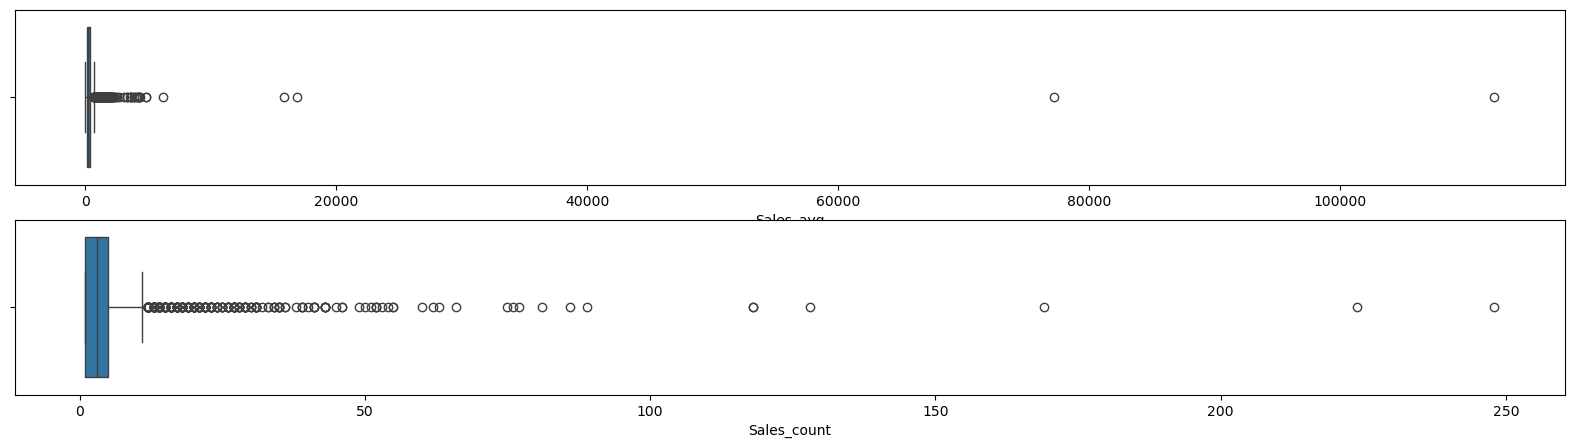


Sales_avg and Sales_count are not normally distributed, and also have outliers => LogScaler 



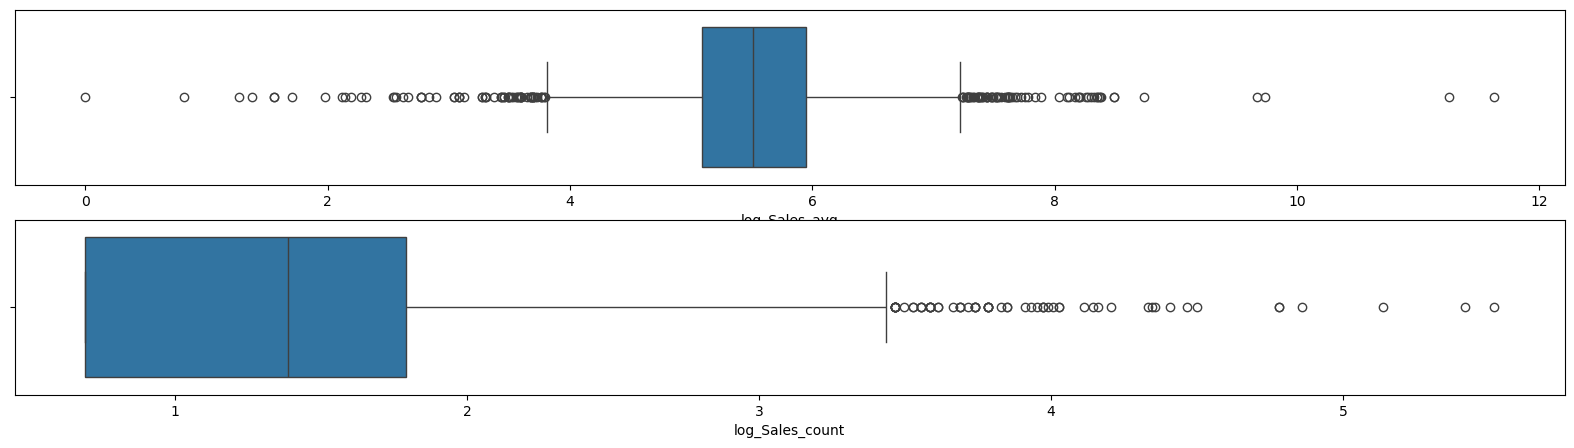

In [7]:
from scipy.stats import shapiro
print(f'Normality test of Sales_avg: {shapiro(retail_processed['Sales_avg'])}')
print(f'Normality test of Sales_count: {shapiro(retail_processed['Sales_count'])}')
print()

plt.figure(figsize = (20,5))
plt.subplot(2,1,1)
sbn.boxplot(data = retail_processed, x = 'Sales_avg')
plt.subplot(2,1,2)
sbn.boxplot(data = retail_processed, x = 'Sales_count')
plt.show()

print('\nSales_avg and Sales_count are not normally distributed, and also have outliers => LogScaler \n')

retail_scaled = (
    retail_processed.copy()
    .assign(log_Sales_avg = lambda df: np.log(df['Sales_avg'] + 1))
    .assign(log_Sales_count = lambda df: np.log(df['Sales_count'] + 1))
    .drop(['Sales_avg', 'Sales_count'], axis = 1)
    
)

plt.figure(figsize = (20,5))
plt.subplot(2,1,1)
sbn.boxplot(data = retail_scaled, x = 'log_Sales_avg')
plt.subplot(2,1,2)
sbn.boxplot(data = retail_scaled, x = 'log_Sales_count')
plt.show()

## <span style = 'color:yellow'> Find optimal K using Elbow Method and Silhoutte Score

Silhouette score for k = 2: 0.5186219618779858
Silhouette score for k = 3: 0.4508637491345442
Silhouette score for k = 4: 0.3830638589196937
Silhouette score for k = 5: 0.3692623313717147
Silhouette score for k = 6: 0.39005973481031053
Silhouette score for k = 7: 0.3976280060256284
Silhouette score for k = 8: 0.3915033767047826
Silhouette score for k = 9: 0.40056045778349364


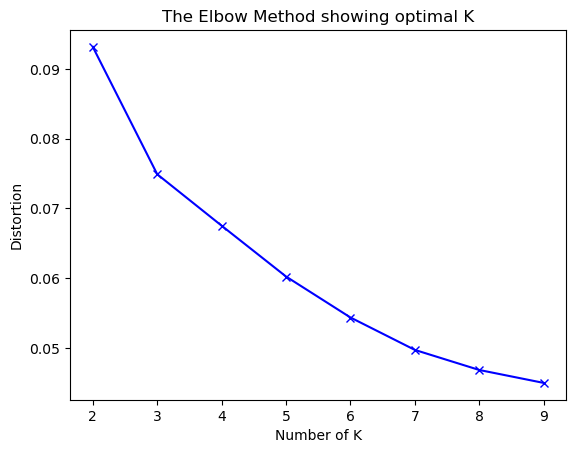


Choose K = 3


In [8]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import cdist
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import make_column_transformer
import math

distortions = []
k_nums = range(2,10)

data = retail_scaled.drop('CustomerID', axis = 1)

for k in k_nums:
    kmeans_pipe = Pipeline([
        ('MinMaxScaler', MinMaxScaler()),
        ('KMeansModel', KMeans(n_clusters = k, random_state = 2))
    ])
    kmeans_pipe.fit(data)
    data_scaled = (
        pd.DataFrame(kmeans_pipe.named_steps['MinMaxScaler'].transform(data))
        .pipe(lambda df: df.set_axis(data.columns, axis =1))
    )
     
    centroids = kmeans_pipe.named_steps['KMeansModel'].cluster_centers_
    sum_var = sum(np.min(cdist(data_scaled, centroids, 'euclidean'), axis = 1)) / data.shape[0]
    distortions.append(sum_var)
    labels = kmeans_pipe.named_steps['KMeansModel'].labels_
    print(f'Silhouette score for k = {k}: {silhouette_score(data_scaled, labels)}')

plt.plot(k_nums, distortions, 'bx-')
plt.xlabel('Number of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing optimal K')
plt.show()

print('\nChoose K = 3')

## <span style = 'color:yellow'> Build official KMeansClustering with K = 3

In [9]:
data = retail_scaled.drop('CustomerID', axis = 1)

kmeans_pipe = Pipeline([
    ('MinMaxScaler', MinMaxScaler()),
    ('KMeansModel', KMeans(n_clusters = 3, random_state = 2))
])
kmeans_pipe.fit(data)

labels = kmeans_pipe.named_steps['KMeansModel'].labels_

centroids = kmeans_pipe.named_steps['KMeansModel'].cluster_centers_
centroids = kmeans_pipe.named_steps['MinMaxScaler'].inverse_transform(centroids)

print('Coordinate of all centroids:\n', centroids)
print()

retail_processed_group = (
    retail_scaled.copy()
    .assign(CustomerID = retail_scaled['CustomerID'])
    .assign(Sales_avg = lambda df: np.exp(df['log_Sales_avg'] - 1))
    .assign(Sales_count = lambda df: np.exp(df['log_Sales_count'] -1))
    .assign(Group = labels)
)

print(retail_processed_group)

Coordinate of all centroids:
 [[5.55840161 1.70277849]
 [5.71012678 2.80971213]
 [5.44841122 0.84867065]]

      CustomerID  log_Sales_avg  log_Sales_count     Sales_avg  Sales_count  Group
0        12346.0      11.253955         1.098612  28394.627515     1.103638      2
1        12347.0       6.424406         2.079442    226.876507     2.943036      0
2        12348.0       6.109936         1.609438    165.659791     1.839397      0
3        12349.0       7.472245         0.693147    646.934391     0.735759      2
4        12350.0       5.815324         0.693147    123.386765     0.735759      2
...          ...            ...              ...           ...          ...    ...
4367     18280.0       5.201806         0.693147     66.806907     0.735759      2
4368     18281.0       4.404522         0.693147     30.099896     0.735759      2
4369     18282.0       4.108138         1.386294     22.379333     1.471518      0
4370     18283.0       4.882271         2.833213     48.534335 

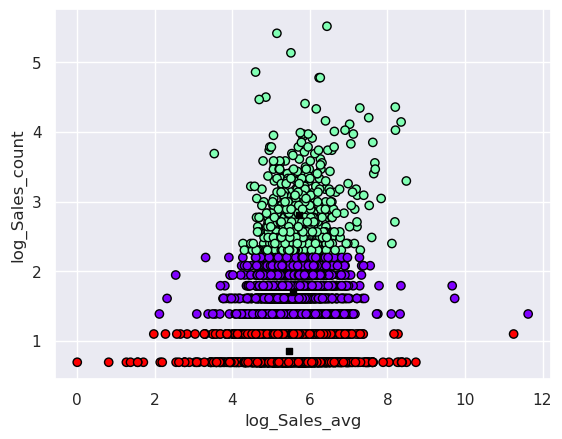

In [16]:
sbn.set_theme(style = 'darkgrid')
plt.scatter(retail_processed_group['log_Sales_avg'], retail_processed_group['log_Sales_count'], 
            c = retail_processed_group['Group'], cmap = 'rainbow', edgecolors = 'black')
plt.scatter(centroids[:,0], centroids[:,1], marker = 's', s = 25, color = 'black')
plt.xlabel('log_Sales_avg')
plt.ylabel('log_Sales_count')
plt.show()

# <span style = 'color:yellow'> Report clustering results

In [215]:
data_group = retail_processed_group.copy()
data_group.drop('CustomerID', axis = 1, inplace = True)

for group in data_group['Group'].unique():
    print(f'\n=============== Cluster group {group} =========================\n')
    data = data_group[data_group['Group'] == group]
    print(f'n_observations: {data.shape[0]}\n')
    for col_name in data.columns[:-1]:
        print(f'{col_name}: {np.min(data[col_name])} ~ {np.median(data[col_name])} ~ {np.max(data[col_name])}')
        print()


=============== Cluster group 2 =========================

n_observations: 2130

log_Sales_avg: 0.0 ~ 5.444849805641221 ~ 11.253955234248428

log_Sales_count: 0.6931471805599453 ~ 0.6931471805599453 ~ 1.0986122886681098

Sales_avg: 0.36787944117144233 ~ 85.18708309626209 ~ 28394.627515041288

Sales_count: 0.7357588823428847 ~ 0.7357588823428847 ~ 1.103638323514327


=============== Cluster group 0 =========================

n_observations: 1625

log_Sales_avg: 2.118261533529418 ~ 5.527380505338336 ~ 11.629062999383567

log_Sales_count: 1.3862943611198906 ~ 1.6094379124341003 ~ 2.1972245773362196

Sales_avg: 3.0595306857424953 ~ 92.51589849197074 ~ 41318.391697818544

Sales_count: 1.4715177646857691 ~ 1.8393972058572114 ~ 3.3109149705429815


=============== Cluster group 1 =========================

n_observations: 617

log_Sales_avg: 3.533454458417486 ~ 5.626361327687616 ~ 8.48696877000709

log_Sales_count: 2.302585092994046 ~ 2.6390573296152584 ~ 5.517452896464707

Sales_avg: 12.596

Number of numeric fields: 2

All numeric fields: ['log_Sales_avg', 'log_Sales_count']



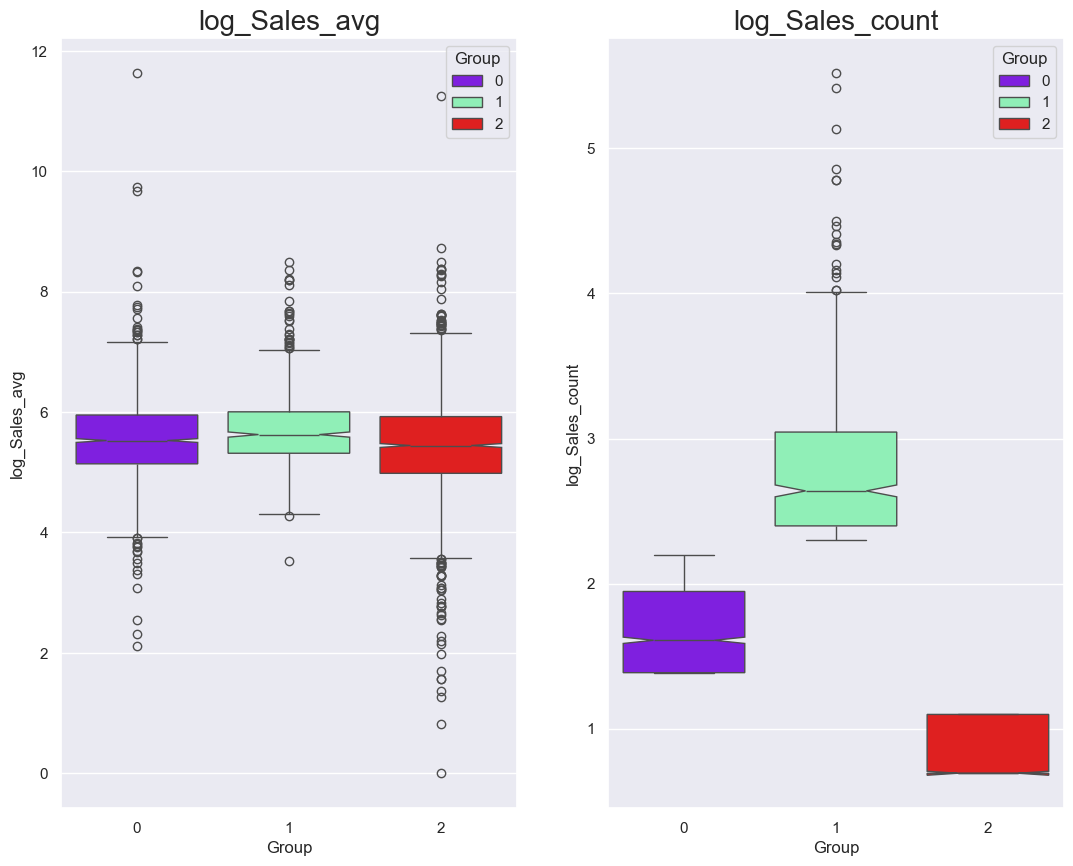

In [217]:
# Method 3
data_group = retail_processed_group.copy()

numeric_cols = ['log_Sales_avg', 'log_Sales_count']

##### Function building ##############

def boxplot_numeric(df, numeric_cols, figsize=(20, 10), groups = retail_processed_group['Group']):
    col = 3
    if (len(numeric_cols) % 3) == 0:
        row = len(numeric_cols) // 3
    else:
        row = (len(numeric_cols) // 3) + 1
    '''
    numeric_cols: list các tên cột biến định lượng
    row: số lượng dòng trong lưới đồ thị
    col: số lượng cột trong lưới đồ thị
    figsize: kích thước biểu đồ
    groups: tên cột chứa biến phân nhóm như 'Group' hoặc 'Class' hoặc 'Label'
    '''
    print(f'Number of numeric fields: {len(numeric_cols)}')
    print()
    print(f'All numeric fields: {numeric_cols}')
    print()
    plt.figure(figsize = figsize)
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.2, hspace=0.3)
    for i in range(1, len(numeric_cols)+1, 1):
      try:
        plt.subplot(row, col, i)
        sbn.boxplot(data = df, x = groups, y = numeric_cols[i-1], notch = True, hue = groups, palette = 'rainbow')
        plt.title(numeric_cols[i-1], size = 20)
      except:
        print('Error {}'.format(numeric_cols[i-1]))
        break
    plt.show()

## Draw
sbn.set_theme(style ='darkgrid')
boxplot_numeric(data_group, numeric_cols, groups = data_group.iloc[:,-1])